In [20]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

import matplotlib.pyplot as plt

%matplotlib inline

from sqlalchemy import create_engine
import warnings

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "useducation"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

ed_df = pd.read_sql_query("select * from useducation", con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [67]:
ed_df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


<IPython.core.display.Javascript object>

In [3]:
ed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

<IPython.core.display.Javascript object>

### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

In order to detect outliers, let's first make sure we don't have any missing data, and drop it if we do.  (Even though we have time series data, and so might want to interpolate the missing value, it would not be prudent to do so without investigating how the missing data is distributed.  Because that's not the point of this problem set, I decided to drop the missing values instead to be safe.). Then visualize the data with boxplot and histogram.  Last, we detect the outliers with statistical methods (Z score and Tukey's Method).

In [69]:
missing_perc_rev = ed_df["TOTAL_REVENUE"].isna().mean() * 100
print(f"Dropping the missing {missing_perc_rev:.2f}% of total revenue data")

missing_perc_exp = ed_df["TOTAL_EXPENDITURE"].isna().mean() * 100
print(f"Dropping the missing {missing_perc_exp:.2f}% of total expenditure data")

dropped_rev = ed_df["TOTAL_REVENUE"].dropna()
dropped_exp = ed_df["TOTAL_EXPENDITURE"].dropna()

Dropping the missing 14.21% of total revenue data
Dropping the missing 14.21% of total expenditure data


<IPython.core.display.Javascript object>

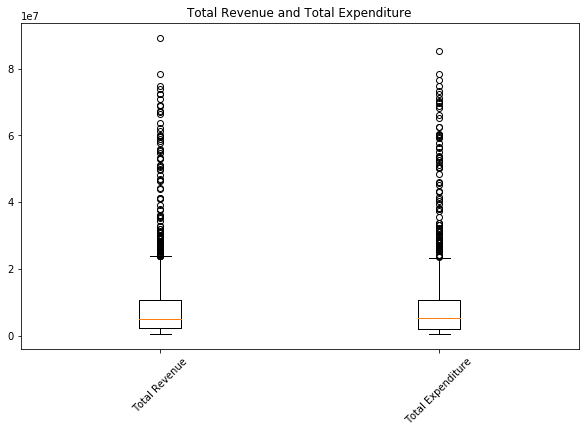

<IPython.core.display.Javascript object>

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.boxplot([dropped_rev, dropped_exp])
plt.title("Total Revenue and Total Expenditure")
ax1.set_xticklabels(("Total Revenue", "Total Expenditure"), rotation=45, fontsize=10)
plt.show()

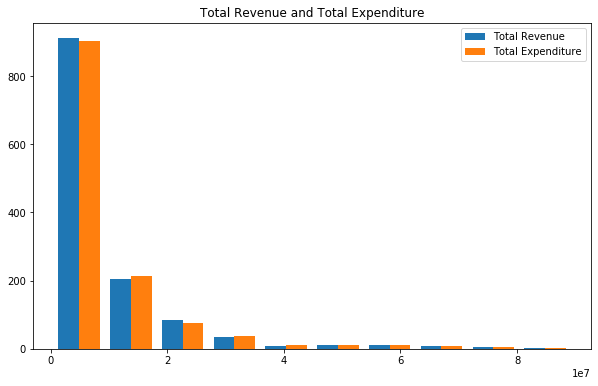

<IPython.core.display.Javascript object>

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist([dropped_rev, dropped_exp])
plt.title("Total Revenue and Total Expenditure")
plt.legend(("Total Revenue", "Total Expenditure"))
plt.show()

Above we see many potential outliers on the high end of distribution.  Really, this just looks logarithmically distributed to me...but let's see what the stats say:

In [21]:
#calculate differnt total revenue Z-score thresholds
#Note: taken directly from the reading
z_scores = zscore(dropped_rev)
for threshold in range(1, 5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   4,   32,   56,   85,  108,  137,  150,  161,  190,  213,  241,
        252,  264,  292,  304,  316,  344,  355,  367,  395,  406,  419,
        448,  459,  471,  480,  500,  511,  523,  551,  563,  575,  603,
        614,  626,  631,  635,  652,  654,  660,  666,  678,  683,  687,
        704,  706,  712,  717,  729,  735,  739,  756,  758,  761,  764,
        769,  782,  787,  791,  809,  811,  814,  817,  822,  834,  840,
        844,  861,  863,  866,  869,  874,  889,  895,  899,  916,  918,
        921,  924,  929,  941,  947,  951,  968,  970,  973,  976,  981,
        993,  998, 1002, 1019, 1021, 1024, 1027, 1032, 1044, 1049, 1053,
       1070, 1072, 1075, 1078, 1083, 1095, 1100, 1104, 1121, 1123, 1126,
       1129, 1134, 1146, 1151, 1155, 1172, 1174, 1177, 1180, 1185, 1197,
       1202, 1206, 1223, 1225, 1228, 1231, 1236, 1248, 1253, 1257, 1274,
       1276, 1279]),)
Number of outliers is: 134
The score threshold

<IPython.core.display.Javascript object>

In [22]:
# calculate differnt total expenditure Z-score thresholds
# Note: taken directly from the reading
z_scores = zscore(dropped_exp)
for threshold in range(1, 5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([   4,   32,   56,   85,  108,  137,  150,  161,  190,  213,  241,
        252,  264,  292,  304,  316,  344,  355,  367,  395,  406,  419,
        448,  459,  471,  480,  500,  511,  523,  551,  563,  575,  584,
        603,  614,  626,  631,  635,  652,  654,  660,  666,  678,  683,
        687,  704,  706,  712,  717,  729,  735,  739,  756,  758,  764,
        769,  782,  787,  791,  809,  811,  814,  817,  822,  834,  840,
        844,  861,  863,  866,  869,  874,  889,  895,  899,  916,  918,
        921,  924,  929,  941,  947,  951,  968,  970,  973,  976,  981,
        993,  998, 1002, 1019, 1021, 1024, 1027, 1032, 1044, 1049, 1053,
       1070, 1072, 1075, 1078, 1083, 1095, 1100, 1104, 1121, 1123, 1126,
       1129, 1134, 1146, 1151, 1155, 1172, 1174, 1177, 1180, 1185, 1197,
       1202, 1206, 1223, 1225, 1228, 1231, 1236, 1248, 1253, 1257, 1274,
       1276, 1279]),)
Number of outliers is: 134
The score threshold

<IPython.core.display.Javascript object>

In [43]:
# Tukey's Method applied to total revenue
# at different thresholds
# note: taken directly from reading
datasets = [dropped_rev, dropped_exp]
dataset_names = ['Total Revenue', "Total Expenditure"]

for i, dataset in enumerate(datasets):
    print(f'Printing score thresholds and number of outliers for {dataset_names[i]}:')
    print('\n')
    q75, q25 = np.percentile(dataset, [75, 25])
    iqr = q75 - q25
    
    for threshold in np.arange(1, 5, 0.5):
        min_val = q25 - (iqr * threshold)
        max_val = q75 + (iqr * threshold)
        print('\t',"The score threshold is: {}".format(threshold))
        print('\t',
            "Number of outliers is: {}".format(
                len((np.where((dataset > max_val) | (dataset < min_val))[0]))
            )
        )
        print('\n')
    print('\n')


Printing score thresholds and number of outliers for Total Revenue:


	 The score threshold is: 1.0
	 Number of outliers is: 146


	 The score threshold is: 1.5
	 Number of outliers is: 110


	 The score threshold is: 2.0
	 Number of outliers is: 74


	 The score threshold is: 2.5
	 Number of outliers is: 52


	 The score threshold is: 3.0
	 Number of outliers is: 45


	 The score threshold is: 3.5
	 Number of outliers is: 40


	 The score threshold is: 4.0
	 Number of outliers is: 37


	 The score threshold is: 4.5
	 Number of outliers is: 32




Printing score thresholds and number of outliers for Total Expenditure:


	 The score threshold is: 1.0
	 Number of outliers is: 152


	 The score threshold is: 1.5
	 Number of outliers is: 111


	 The score threshold is: 2.0
	 Number of outliers is: 80


	 The score threshold is: 2.5
	 Number of outliers is: 55


	 The score threshold is: 3.0
	 Number of outliers is: 49


	 The score threshold is: 3.5
	 Number of outliers is: 43


	 The scor

<IPython.core.display.Javascript object>

So we see from the two outlier detection methods that there are outliers in both variables at the high end of the revenue and expenditure distributions, if we're not taking into account that these variables are probably logarithmically distributed, and therefore should be transformed before such outlier analysis.  In fact, let's transform these data and recalculate the outliers.

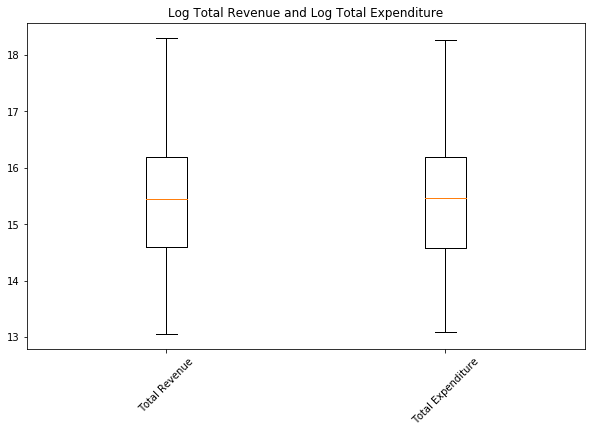

<IPython.core.display.Javascript object>

In [44]:
log_rev = np.log(dropped_rev)
log_exp = np.log(dropped_exp)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.boxplot([log_rev, log_exp])
plt.title("Log Total Revenue and Log Total Expenditure")
ax1.set_xticklabels(("Total Revenue", "Total Expenditure"), rotation=45, fontsize=10)
plt.show()

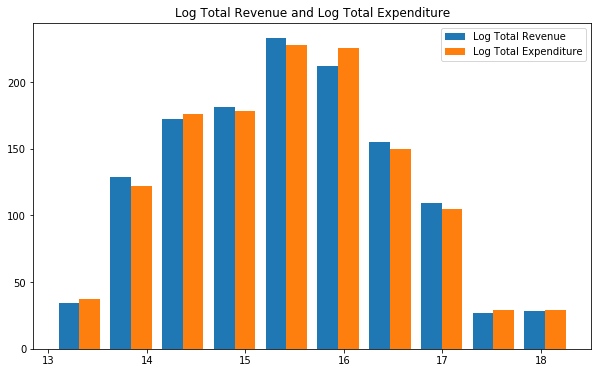

<IPython.core.display.Javascript object>

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist([log_rev, log_exp])
plt.title("Log Total Revenue and Log Total Expenditure")
plt.legend(("Log Total Revenue", "Log Total Expenditure"))
plt.show()

In [49]:
# calculate different total expenditure Z-score thresholds
# Note: taken directly from the reading


datasets = [log_rev, log_exp]
dataset_names = ["Log Total Revenue", "Log Total Expenditure"]

for i, dataset in enumerate(datasets):
    z_scores = zscore(dataset)
    print(f"Thresholds and Z-scores for {dataset_names[i]}:")
    for threshold in range(1, 5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        print(np.where(z_scores > threshold))
        print(
            "Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0])))
        )
    print("\n")

Thresholds and Z-scores for Log Total Revenue:
The score threshold is: 1
The indices of the outliers:
(array([   4,   32,   44,   56,   85,   96,  108,  137,  148,  150,  161,
        190,  201,  213,  241,  252,  264,  292,  299,  304,  316,  321,
        344,  350,  355,  367,  372,  376,  385,  393,  395,  401,  406,
        419,  424,  428,  437,  446,  448,  451,  454,  459,  471,  476,
        480,  481,  490,  498,  500,  503,  506,  511,  523,  528,  532,
        541,  549,  551,  554,  558,  563,  575,  580,  584,  593,  601,
        603,  606,  609,  614,  626,  631,  635,  644,  652,  654,  657,
        660,  663,  666,  678,  683,  687,  696,  704,  706,  709,  712,
        717,  729,  733,  735,  736,  739,  748,  756,  758,  761,  764,
        769,  782,  787,  788,  791,  800,  809,  811,  814,  817,  822,
        834,  840,  841,  844,  853,  861,  863,  866,  869,  874,  889,
        895,  896,  899,  907,  908,  916,  918,  919,  921,  924,  929,
        932,  941,  9

<IPython.core.display.Javascript object>

In [50]:
# Tukey's Method applied to total revenue
# at different thresholds
# note: taken directly from reading
datasets = [log_rev, log_exp]
dataset_names = ["Total Revenue", "Total Expenditure"]

for i, dataset in enumerate(datasets):
    print(f"Printing score thresholds and number of outliers for {dataset_names[i]}:")
    print("\n")
    q75, q25 = np.percentile(dataset, [75, 25])
    iqr = q75 - q25

    for threshold in np.arange(1, 5, 0.5):
        min_val = q25 - (iqr * threshold)
        max_val = q75 + (iqr * threshold)
        print("\t", "The score threshold is: {}".format(threshold))
        print(
            "\t",
            "Number of outliers is: {}".format(
                len((np.where((dataset > max_val) | (dataset < min_val))[0]))
            ),
        )
        print("\n")
    print("\n")

Printing score thresholds and number of outliers for Total Revenue:


	 The score threshold is: 1.0
	 Number of outliers is: 25


	 The score threshold is: 1.5
	 Number of outliers is: 0


	 The score threshold is: 2.0
	 Number of outliers is: 0


	 The score threshold is: 2.5
	 Number of outliers is: 0


	 The score threshold is: 3.0
	 Number of outliers is: 0


	 The score threshold is: 3.5
	 Number of outliers is: 0


	 The score threshold is: 4.0
	 Number of outliers is: 0


	 The score threshold is: 4.5
	 Number of outliers is: 0




Printing score thresholds and number of outliers for Total Expenditure:


	 The score threshold is: 1.0
	 Number of outliers is: 28


	 The score threshold is: 1.5
	 Number of outliers is: 0


	 The score threshold is: 2.0
	 Number of outliers is: 0


	 The score threshold is: 2.5
	 Number of outliers is: 0


	 The score threshold is: 3.0
	 Number of outliers is: 0


	 The score threshold is: 3.5
	 Number of outliers is: 0


	 The score threshold is: 

<IPython.core.display.Javascript object>

### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

Total revenue and total expenditure appear to follow a log-normal distribution.  When they are logarithmically transformed, there are no outliers for both moderately low z-score and iqr method detection thresholds.  I would not choose to winsorize or drop any values instead of just applying a log transformation, unless I had reason to believe that the higher values were incorrectly reported.

### 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

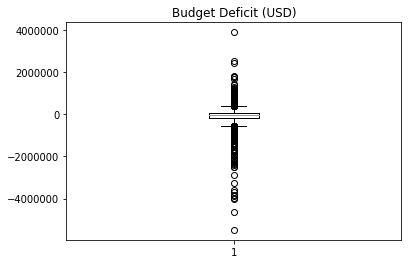

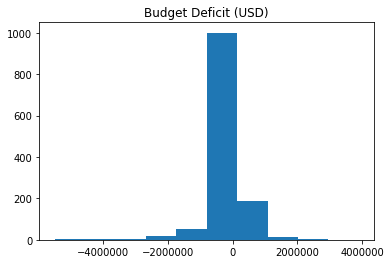

<IPython.core.display.Javascript object>

In [56]:
budget_def = (ed_df["TOTAL_REVENUE"] - ed_df["TOTAL_EXPENDITURE"]).dropna()

plt.boxplot(budget_def)
plt.title("Budget Deficit (USD)")
plt.show()

plt.hist(budget_def)
plt.title("Budget Deficit (USD)")
plt.show()

### 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?